In [35]:
from datetime import datetime

import time
import os
import sys
from pathlib import Path

import numpy as np
from scipy.stats import lognorm
import pandas as pd

from astropy import stats
from astropy.io import fits
from astropy.nddata import CCDData
import astropy.units as u
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.table import Table
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

import ccdproc
import photutils

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

from mmtwfs.wfs import wfs_norm

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
%cd /Users/tim/MMT/sky_brightness/asi_skycam/Bias/

/Volumes/LaCie 8TB/sky_brightness/asi_skycam/Bias


In [4]:
biases = ccdproc.ImageFileCollection('.', keywords="*", glob_include="Bias*")

In [ ]:
for h in biases.hdus(save_location='reduced', overwrite=True, ccd_kwargs={'unit': 'adu', 'gain': 1.0}):
    h.header['fixscale'] = True
    h.data = h.data / 16

In [ ]:
scaled_biases = ccdproc.ImageFileCollection('./reduced', keywords="*", glob_include="Bias_*")

In [ ]:
bias = ccdproc.combine(
    list(scaled_biases.ccds(ccd_kwargs={'unit': 'adu'})),
    method='average',
    mem_limit=1e9,
    clip_extreme=True,
    nlow=2,
    nhigh=2,
    dtype=np.float64
)
bias.write("./bias.fits", overwrite=True)

In [9]:
%cd ../Light

/Volumes/LaCie 8TB/sky_brightness/asi_skycam/Light


In [ ]:
filters = ['clear', 'u', 'g', 'r', 'i']
#filters = ['u']
for f in filters:
    rpath = f"{f}/reduced"
    if not Path.exists(Path(rpath)):
        Path.mkdir(Path(rpath))
    ic = ccdproc.ImageFileCollection(f"./{f}", keywords="*", glob_include="Light_*")
    for h in ic.hdus(save_location=rpath, overwrite=True, ccd_kwargs={'unit': u.adu, 'gain': 1.0}):
        h.header['fixscale'] = True
        h.data = h.data / 16
        h.data = h.data - bias.data

In [10]:
test_im = CCDData.read("./r/reduced/Light_024.fits", unit=u.adu, gain=1.0)
test_im.header['GAIN'] = 1.0

In [11]:
sigma = 3.0 * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
npixels = 5
threshold = photutils.detect_threshold(test_im.data, snr=5.)
segm = photutils.detect_sources(test_im.data, threshold, npixels=npixels, filter_kernel=kernel)
segm.remove_border_labels(border_width=10)
#segm = photutils.deblend_sources(test_im.data, segm_raw, npixels=npixels, filter_kernel=kernel, nlevels=32, contrast=0.001)

<IPython.core.display.Javascript object>


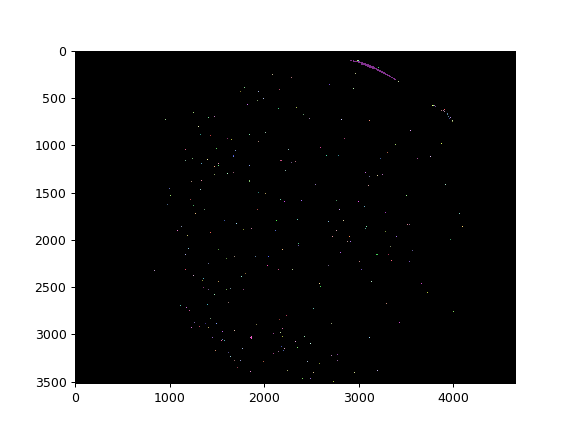

In [12]:
plt.imshow(segm, cmap=segm.cmap(random_state=12345))
plt.show()

In [160]:
sigma_clip = stats.SigmaClip(sigma=2.)
#bkg_estimator = photutils.MedianBackground()
bkg_estimator = photutils.SExtractorBackground()
mask = photutils.make_source_mask(test_im.data, snr=2, npixels=7)
bkg = photutils.Background2D(
    test_im.data,
    (7, 7),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
    mask=mask
)

/Users/tim/conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


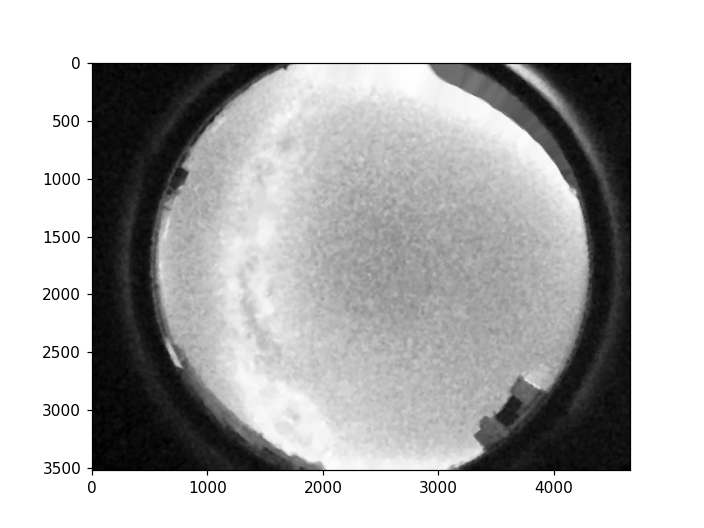

In [161]:
plt.imshow(bkg.background, cmap='Greys_r', norm=wfs_norm(bkg.background))
plt.show()

In [162]:
fits.writeto('bkg.fits', bkg.background, overwrite=True)

In [163]:
diff = test_im.data - bkg.background
fits.writeto('diff.fits', diff, overwrite=True)

In [164]:
xmid = int(diff.shape[1]/2)
ymid = int(diff.shape[0]/2)
xl = xmid - 900
xu = xmid + 900
yl = ymid - 900
yu = ymid + 900
fits.writeto("diff_trim.fits", diff[yl:yu,xl:xu], overwrite=True)

In [96]:
0.0373412253334 * 3600

134.42841120024

In [165]:
diff_trim_hdul = fits.open("diff_trim.new")
diff_trim = diff_trim_hdul[0].data
w = WCS(diff_trim_hdul[0])

In [166]:
sigma = 2.0 * gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=5, y_size=5)
kernel.normalize()
npixels = 7
threshold = photutils.detect_threshold(diff_trim, snr=5.)
segm_raw = photutils.detect_sources(diff_trim, threshold, npixels=npixels, filter_kernel=kernel)
segm_trim = photutils.deblend_sources(diff_trim, segm_raw, npixels=npixels, filter_kernel=kernel, nlevels=32, contrast=0.001)

/Users/tim/conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


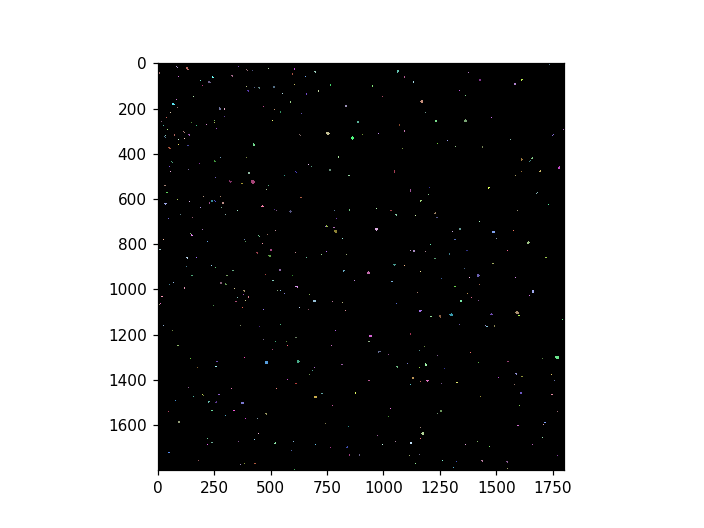

In [167]:
plt.imshow(segm_trim, cmap=segm.cmap(random_state=12345))
plt.show()

In [168]:
cat_trim = photutils.source_properties(diff_trim, segm_trim, wcs=w)

In [170]:
t_trim = cat_trim.to_table()
t_trim.write("diff_trim_cat.csv", overwrite=True)

In [171]:
phot_cat = Table.read("bright_star_sloan.fits")

In [172]:
t_trim[0]['sky_centroid_icrs']

<SkyCoord (ICRS): (ra, dec) in deg
    (297.91539836, 45.67359032)>

In [173]:
phot_cat['coords'] = SkyCoord(phot_cat['_RAJ2000'], phot_cat['_DEJ2000'], frame='icrs', unit='deg')

In [174]:
idx, d2d, d3d = t_trim['sky_centroid_icrs'].match_to_catalog_sky(phot_cat['coords'])

In [175]:
max_sep = 10. * u.arcmin
sep_constraint = d2d < max_sep
c_matches = t_trim[sep_constraint]
phot_matches = phot_cat[idx[sep_constraint]]

In [176]:
phot_matches

_RAJ2000,_DEJ2000,HD,Vmag,U-B,B-V,V-R,R-I,V-Rc,Rc-Ic,u_mag,e_u_mag,g_mag,e_g_mag,r_mag,e_r_mag,i_mag,e_i_mag,z_mag,e_z_mag,Simbad,_RA,_DE,coords
deg,deg,,mag,mag,mag,mag,mag,mag,mag,mag,cmag,mag,cmag,mag,cmag,mag,cmag,mag,cmag,,deg,deg,"deg,deg"
float64,float64,int32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,int16,float32,int16,float32,int16,float32,int16,bytes6,float64,float64,object
250.7435792,55.6901175,151199,6.16,0.11,0.07,nan,nan,nan,nan,7.38,14,6.10,3,6.24,2,nan,0,nan,0,Simbad,250.74358,55.69012,"250.74357916666662,55.69011749999999"
289.0920619,38.1337286,180809,4.37,1.23,1.25,0.87,0.59,0.62,0.52,7.76,7,4.96,4,3.95,5,3.65,3,3.49,3,Simbad,289.09206,38.13373,"289.0920619444444,38.133728611111096"
240.6995736,46.0367047,144206,4.76,-0.32,-0.11,0.02,-0.10,0.00,-0.07,5.30,9,4.60,2,4.91,3,5.19,3,5.41,4,Simbad,240.69957,46.03670,"240.69957361111105,46.036704722222225"
248.5257639,42.4370406,149630,4.20,-0.10,-0.01,0.03,-0.01,0.00,0.02,5.09,12,4.10,3,4.32,2,4.52,2,4.68,3,Simbad,248.52576,42.43704,"248.52576388888886,42.437040555555555"
238.6577111,43.1385661,142780,5.38,1.97,1.64,1.49,1.25,0.99,1.17,9.99,13,6.19,5,4.71,7,3.77,4,3.21,4,Simbad,238.65771,43.13857,"238.65771111111107,43.13856611111111"
238.1689225,42.4515183,142373,4.62,0.00,0.57,0.48,0.32,0.33,0.33,5.97,4,4.84,3,4.48,2,4.37,2,4.33,2,Simbad,238.16892,42.45152,"238.16892249999995,42.45151833333333"
259.4177261,37.2914997,156729,4.66,-0.03,0.05,0.09,0.00,0.05,0.03,5.68,11,4.59,3,4.75,2,4.94,2,5.09,3,Simbad,259.41773,37.29150,"259.41772611111105,37.29149972222221"
250.7240211,38.9222536,150997,3.50,0.61,0.92,0.67,0.48,0.47,0.45,5.87,4,3.91,4,3.21,3,2.99,2,2.88,2,Simbad,250.72402,38.92225,"250.72402111111109,38.9222536111111"


/Users/tim/conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>


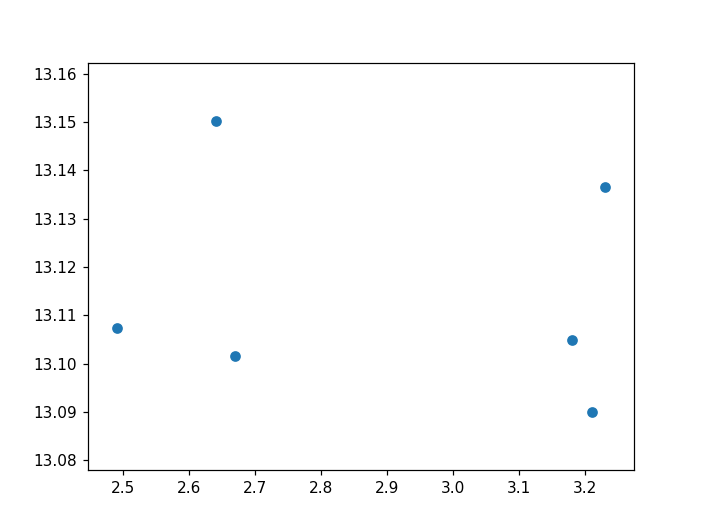

In [183]:
c_matches['obs_mag'] = -2.5 * np.log10(c_matches['source_sum'])
phot_off = phot_matches['r_mag'] - c_matches['obs_mag']
cut = phot_matches['r_mag'] < 3.5
plt.scatter(phot_matches['r_mag'][cut], phot_off[cut])
#plt.scatter(phot_matches['r_mag'], c_matches['obs_mag'])
plt.show()

In [185]:
r_zp = phot_off[cut].mean()

In [191]:
sky_mag = r_zp + (-2.5 * np.log10(11.2/137.**2))
sky_mag

21.175655563058648

In [67]:
c_matches.columns

<TableColumns names=('id','xcentroid','ycentroid','sky_centroid','sky_centroid_icrs','source_sum','source_sum_err','background_sum','background_mean','background_at_centroid','xmin','xmax','ymin','ymax','min_value','max_value','minval_xpos','minval_ypos','maxval_xpos','maxval_ypos','area','equivalent_radius','perimeter','semimajor_axis_sigma','semiminor_axis_sigma','eccentricity','orientation','ellipticity','elongation','covar_sigx2','covar_sigxy','covar_sigy2','cxx','cxy','cyy','obs_mag')>

/Users/tim/conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


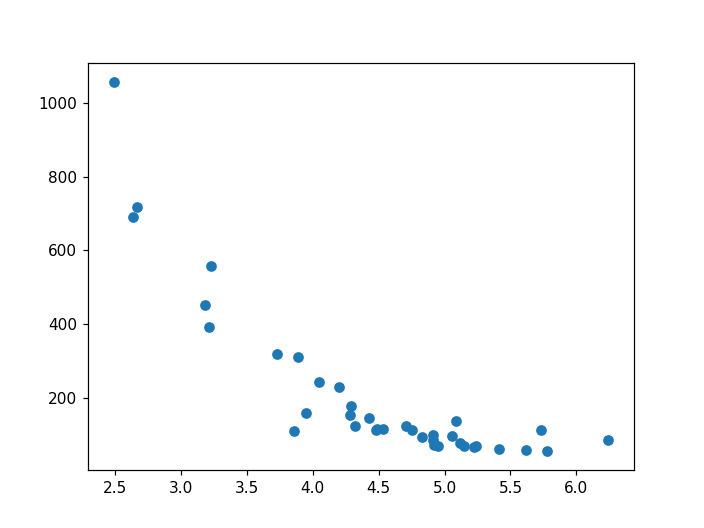

In [182]:
plt.scatter(phot_matches['r_mag'], c_matches['max_value'])
plt.show()

In [112]:
t_trim.show_in_notebook()

idx,id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,xmin,xmax,ymin,ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,eccentricity,orientation,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy
,,pix,pix,"deg,deg","deg,deg",,,,,,pix,pix,pix,pix,,,pix,pix,pix,pix,pix2,pix,pix,pix,pix,,rad,,,pix2,pix2,pix2,1 / pix2,1 / pix2,1 / pix2
0,1,85.68912869574093,1.164521815165976,"298.43268060439846,45.72617531608975","298.43267382373693,45.72616925154793",533.81508881676,None,None,None,None,84.0,87.0,0.0,3.0,6.313666274982538,97.48769293244817,85.0,2.0,86.0,1.0,12.0,1.9544100476116797,10.242640687119284,1.260275719320992,0.5495404596069721,0.8999235038552453,0.8195093193498288,0.5639521961884245,2.293326537271402,0.9013016451863763,0.6416539648721252,0.988987960268709,2.0618663981664347,-2.675471901721916,1.879055814104144
1,2,1730.7268567288984,5.128665926732094,"209.36940807816836,62.634190667854554","209.3694134193661,62.63419015971594",594.5148112426333,None,None,None,None,1728.0,1733.0,2.0,8.0,16.25603912262205,59.464925029582844,1731.0,3.0,1729.0,8.0,16.0,2.256758334191025,15.65685424949238,2.3722830095137404,0.4835339666509944,0.9790070419429184,-0.9638651009991254,0.7961735742692407,4.906135190345395,1.9884396814625778,-2.5269782005191512,3.8730920926702352,2.943546170721024,3.841001880492578,1.511212196879009
2,3,587.3872487236926,14.84876055839013,"283.0369358128429,55.85493064835713","283.03693124423336,55.854924692844726",890.1785779048196,None,None,None,None,585.0,589.0,11.0,19.0,7.614797615069989,64.61674383010111,589.0,16.0,588.0,16.0,26.0,2.876813695875796,19.27817459305202,2.46558417859861,0.7416283411928507,0.9536897234280564,1.2538918657896259,0.6992078600965156,3.3245549578551867,1.0869493009099198,1.6372146507618492,5.542168637306321,1.6575530289325193,-0.9793170439151351,0.3250850387141949
3,4,83.51042162595489,16.116609776962594,"298.12591736664154,45.37162624262143","298.1259106240409,45.371620175976496",814.271485871472,None,None,None,None,81.0,86.0,13.0,19.0,11.560218367720381,79.18173796859615,85.0,16.0,83.0,15.0,20.0,2.5231325220201604,15.692388155425117,2.175554162596983,0.5644451496409756,0.9657568351546603,0.825071031749063,0.740551092983504,3.854323425368752,2.3508674274814987,2.2002743938433134,2.7007668138647842,1.7910338655024516,-2.918257090942284,1.5589954505923496
4,5,356.54366560885506,14.76989643047908,"291.1957203220377,51.05303580492606","291.1957144040804,51.05302973716745",378.52334859141746,None,None,None,None,355.0,358.0,13.0,17.0,16.57773328984103,54.434293268887124,355.0,14.0,356.0,14.0,10.0,1.7841241161527712,10.242640687119284,1.592878495580178,0.4202110388888127,0.9645757356572301,0.9382832682240393,0.7361939155718477,3.790663138675068,1.001603827108822,1.1255925646840672,1.7122353917769646,3.8217586492601563,-5.024709967196614,2.2356085546232163
5,6,128.8416771155971,23.361041583339695,"296.9532150048305,46.13610140209572","296.9532083811754,46.13609532901449",36706.59659263336,None,None,None,None,123.0,134.0,17.0,29.0,7.00618234223602,2780.6903320373876,123.0,25.0,128.0,22.0,105.0,5.781222885281108,38.384776310850235,2.6774144593594915,1.1310391433350933,0.9063922519158002,0.8262841732339287,0.5775629210556861,2.3672164443969677,3.9833772003555468,2.9348098671787204,4.464420530587914,0.48683143932953604,-0.6400641256835139,0.4343751316783264
6,7,488.354328515233,26.11078060601975,"286.5319811003431,53.55734021847818","286.53197589082254,53.55733419993249",406.78364171229475,None,None,None,None,487.0,490.0,24.0,28.0,18.38125051095954,49.46837715888857,490.0,27.0,488.0,25.0,12.0,1.9544100476116797,7.621320343559642,1.5196005142719462,0.54626030551697,0.933154231845628,0.9738277191297551,0.6405237426635855,2.781824889937456,0.9338066860078091,0.9348393412026332,1.6737793583512481,2.42907